### Step 1 - loading the video data

First load the libraries

In [1]:
#load libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data,filters
from skimage.measure import compare_ssim as ssim
from sklearn.cluster import KMeans
from collections import Counter

Then import the video as image frames

In [2]:
vs = cv2.VideoCapture("football-video-5-min.mp4")
frames = []
while True:
    (grabbed,tmp) = vs.read()
    frames.append(tmp)
    if not grabbed:
        break

### Step 2 - splitting frames based on similarity

Look at the similarity index between frames to find when the camera angle switches

In [3]:
#get the similarity index for each frame
simIdx = np.zeros(np.shape(frames))
for i in np.arange(np.shape(frames)[0]-1):
    simIdx[i] = ssim(frames[i+1], frames[i], multichannel=True)

AttributeError: 'NoneType' object has no attribute 'shape'

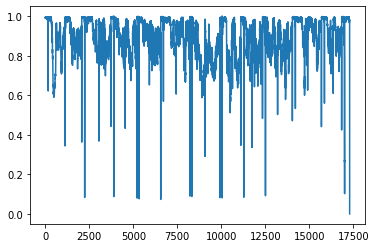

In [6]:
#plot and save the results    
np.savetxt('results/simidx-5-min-video.csv',simIdx,delimiter=',')
plt.plot(simIdx)

Check that the similarity index is capturing when the camera angle is changing

In [49]:
win2view = np.arange(numplots)-(numplots/2)

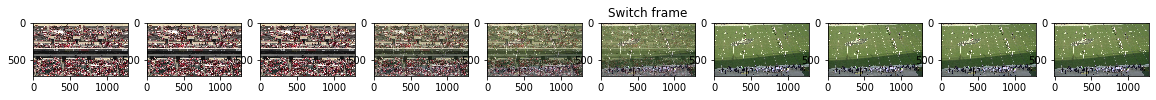

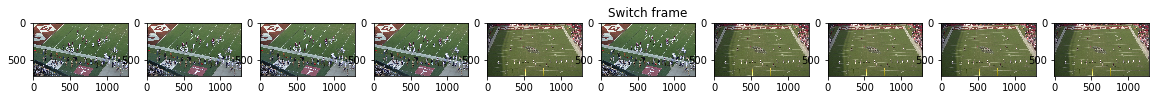

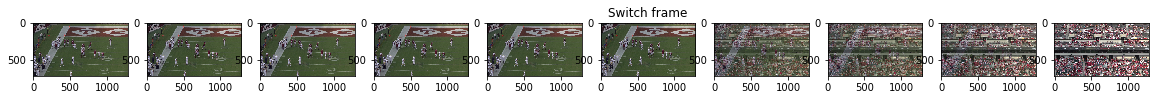

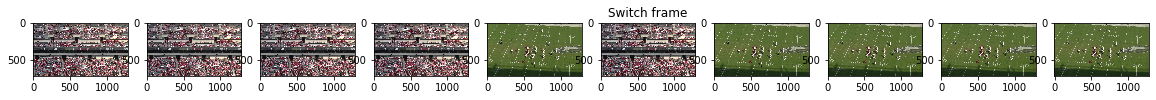

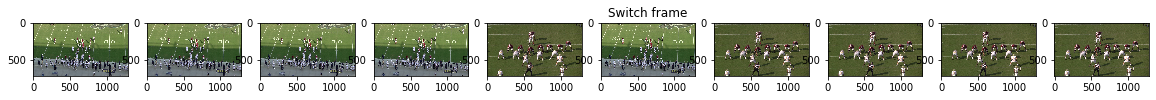

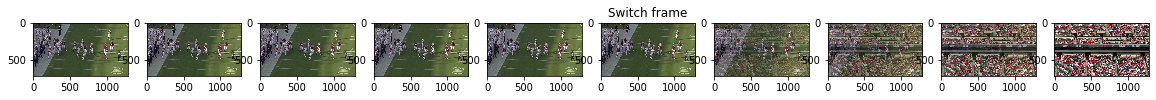

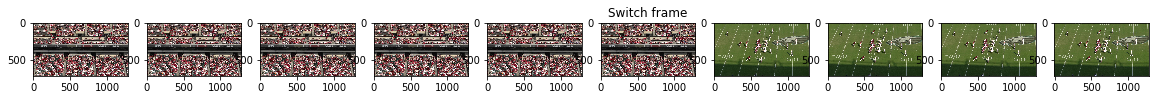

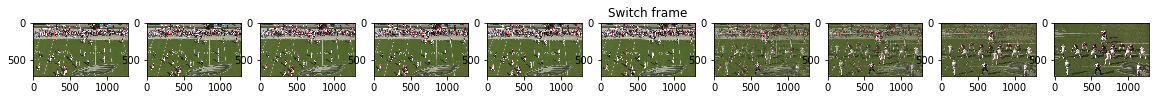

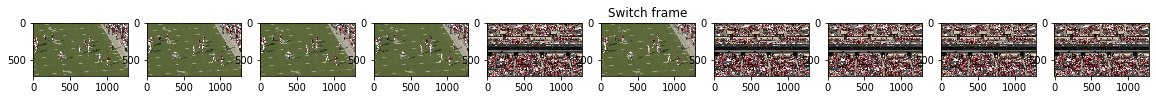

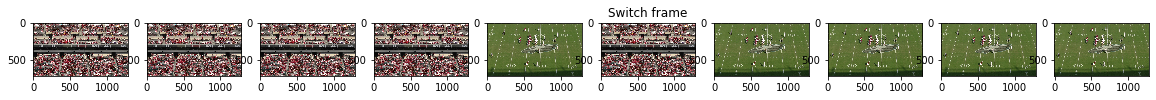

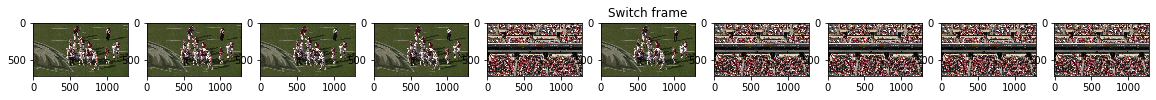

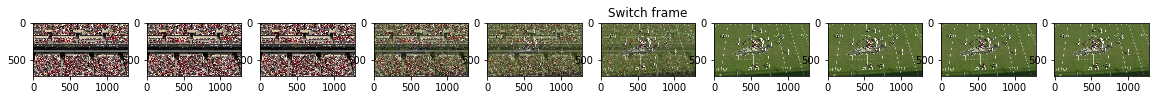

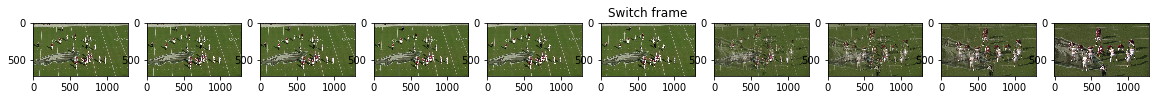

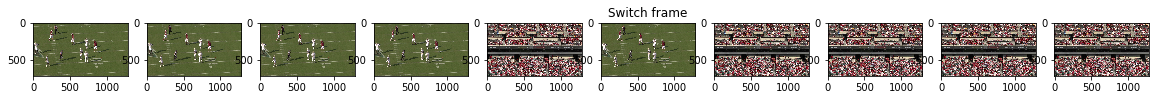

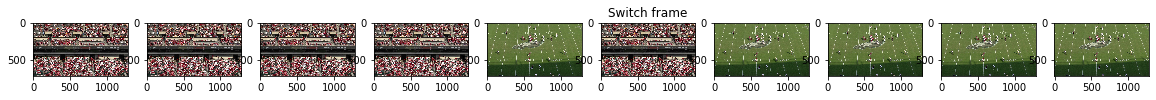

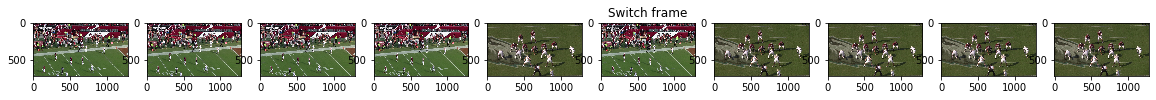

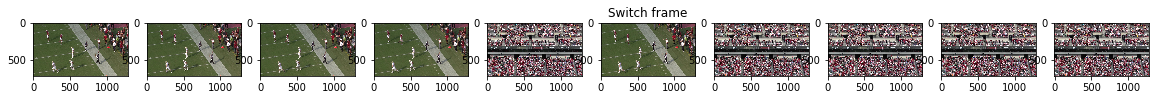

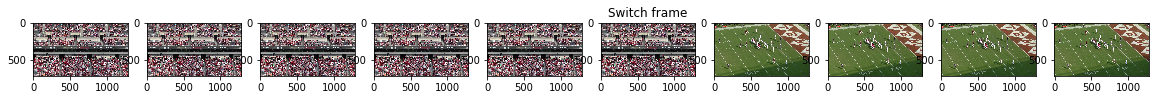

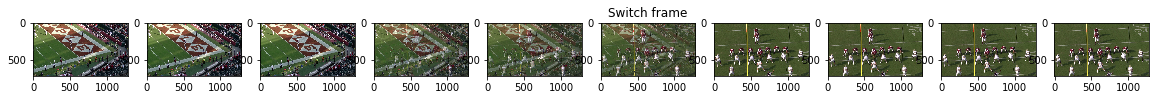

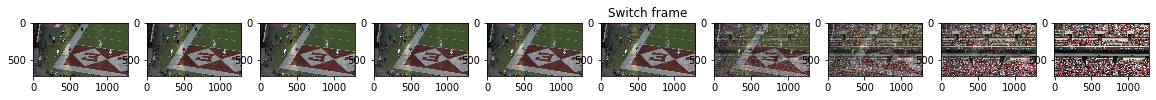

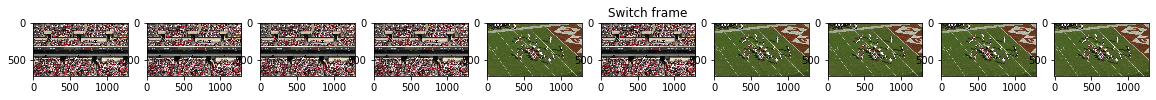

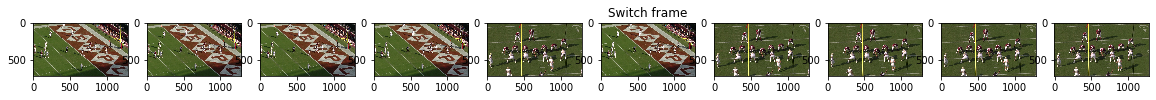

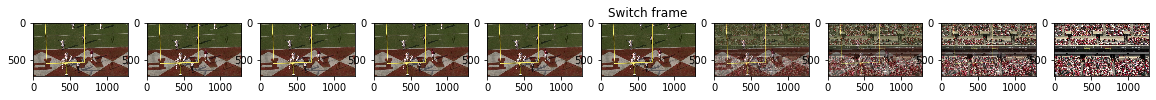

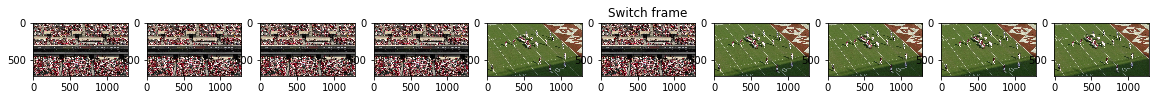

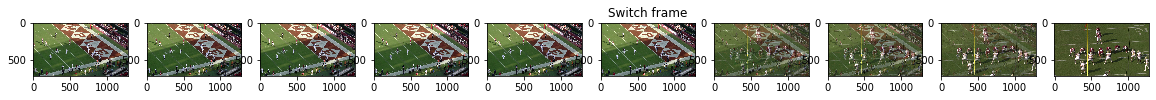

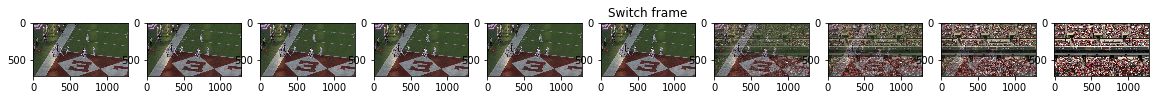

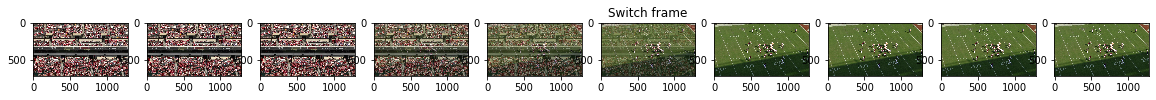

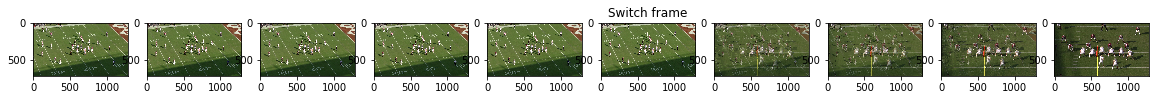

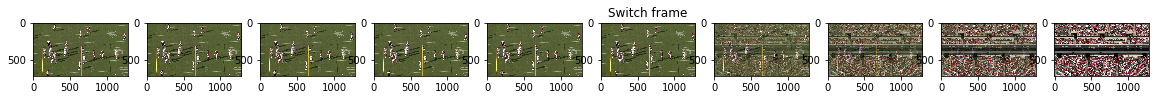

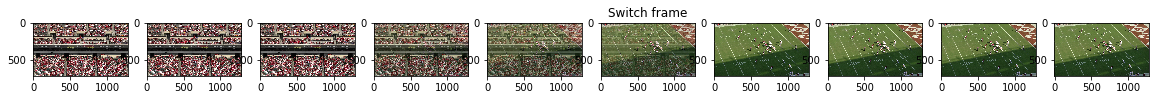

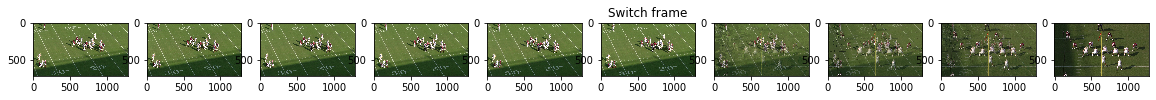

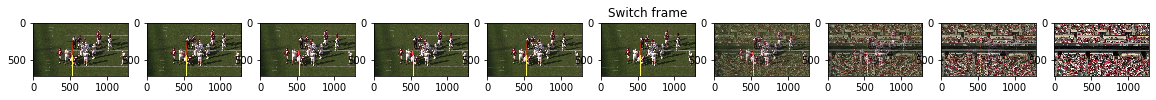

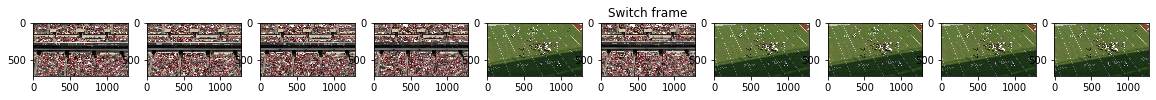

In [51]:
#get indices where the similarity diff is greater than 25%
switchFrames = [i for i, val in enumerate(np.diff(simIdx)>0.25) if val] 

#plot the figures around the switch frames
numplots = 10
for i in np.arange(np.shape(switchFrames)[0]):
    fig, ax = plt.subplots(1,numplots, figsize=(20, 10))
    win2view = np.arange(numplots)
    for j in win2view:
        ax[j].imshow(cv2.cvtColor(frames[int(switchFrames[i]+j-5)], cv2.COLOR_BGR2RGB)) #need to switch the color order first
        if j == 5:
            ax[j].set_title('Switch frame')
        count=count+1
    
    #save the plot figures to a folder
    filename = "figures/videoframes-prepostswitch/switchframe" + str(i) + ".png"
    plt.gcf()
    plt.savefig(filename)
    plt.show()

We can conclude from this that the frame after the detected switch is the best estimate of when the next play or view angle is starting 

### Step 3 - identifying play start/end times versus camera view angle switch times

First we will get images from the times around the switch frames and calculate their RGB histograms

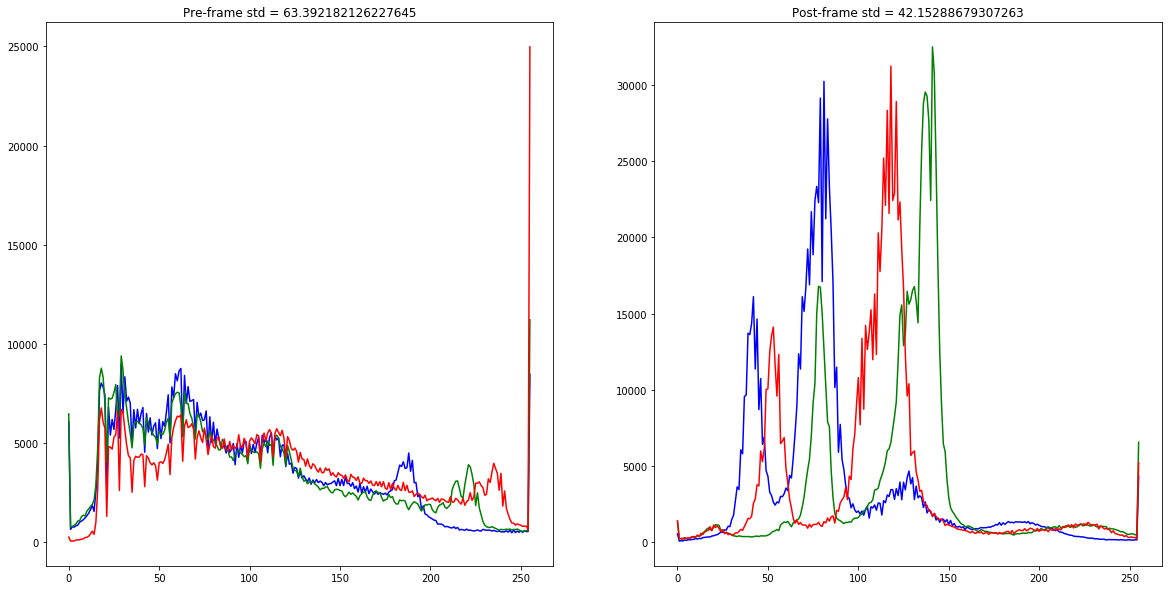

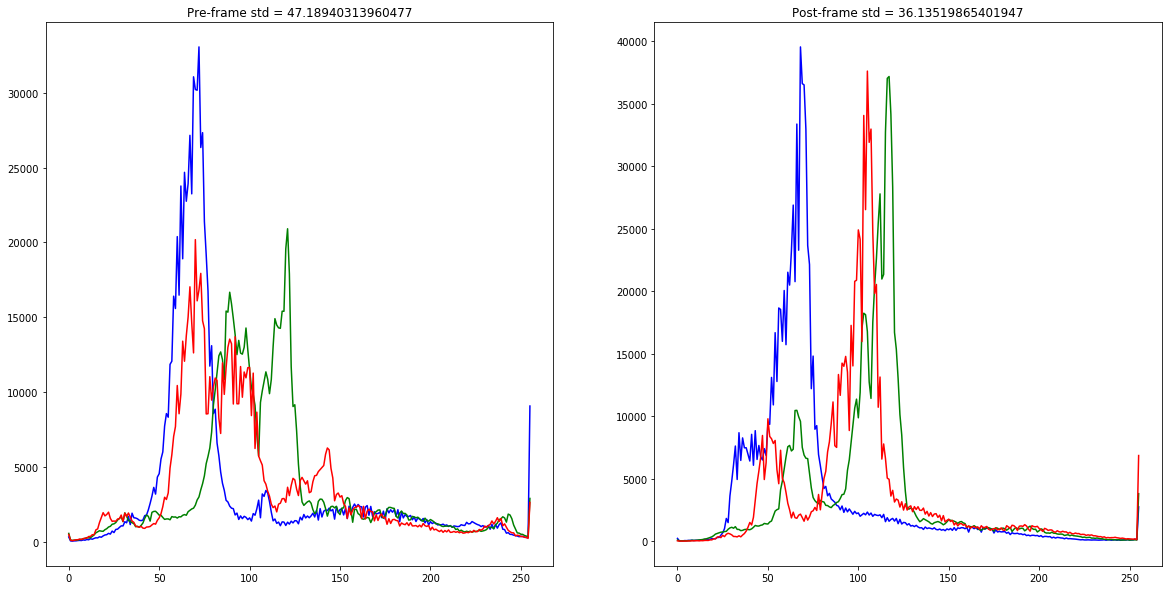

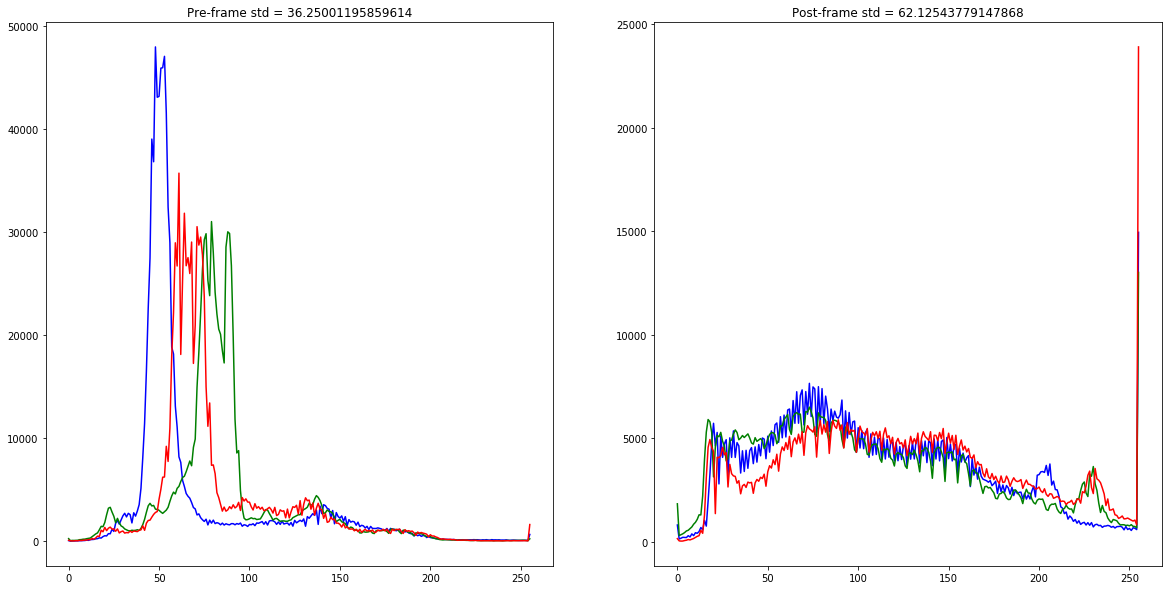

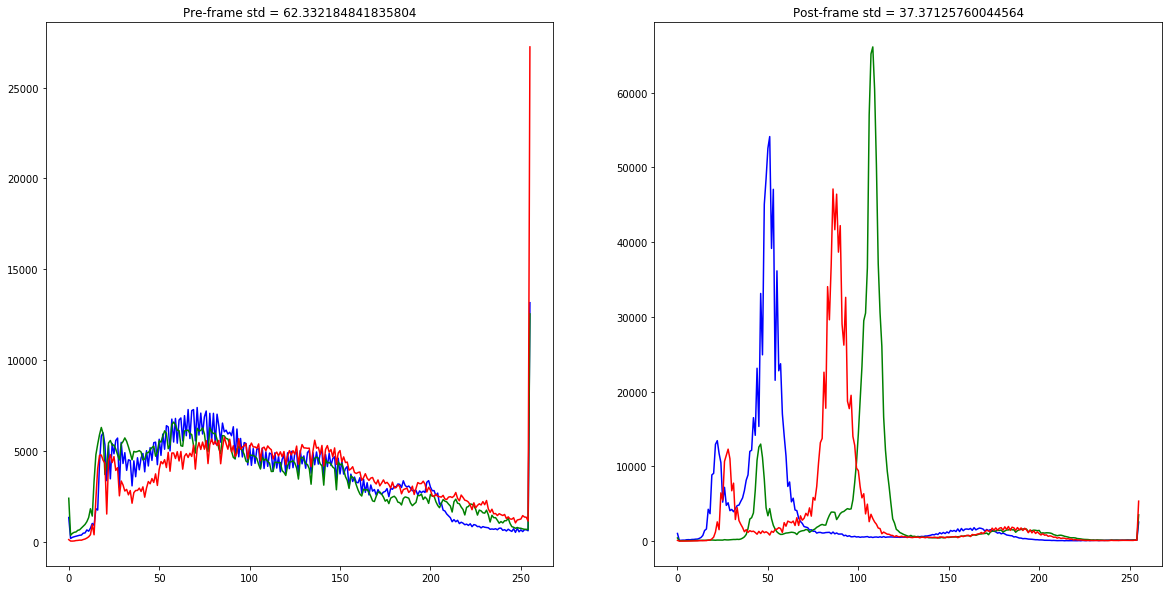

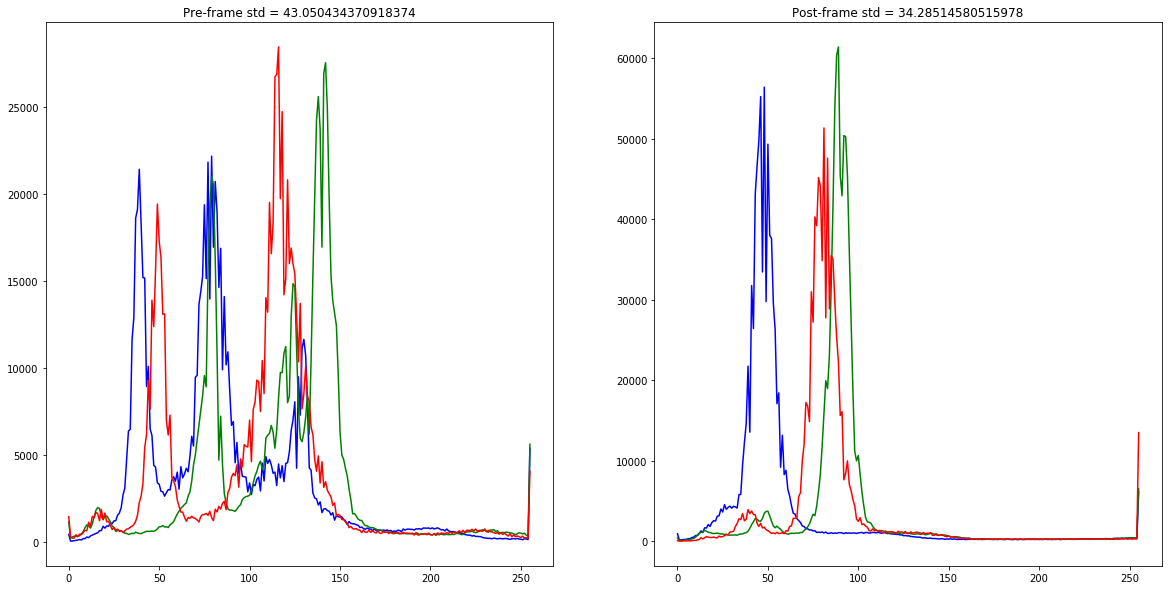

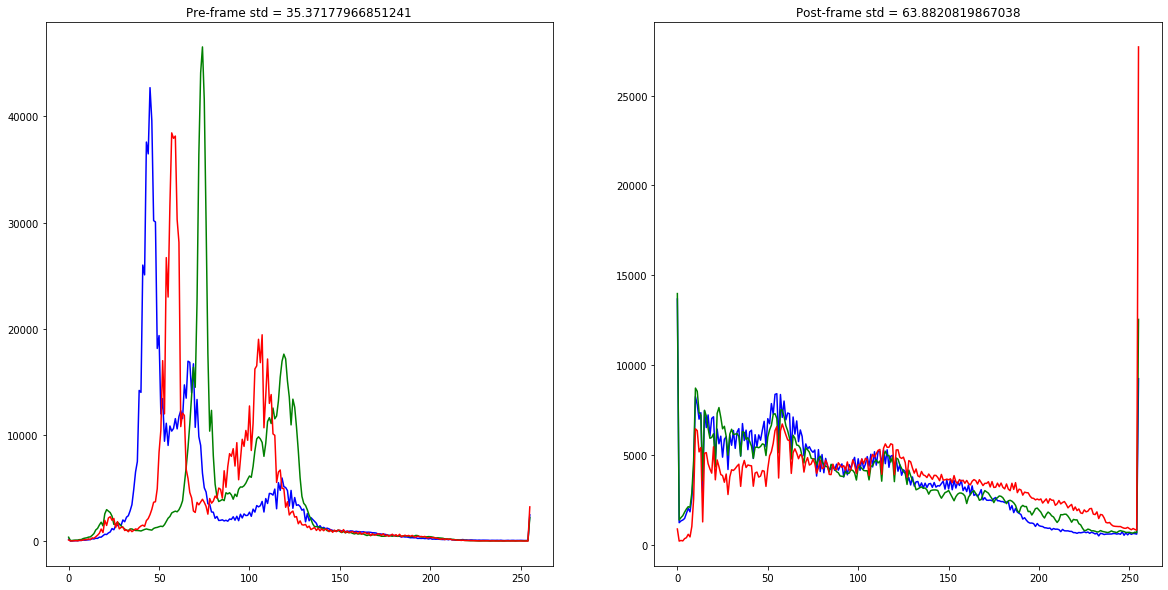

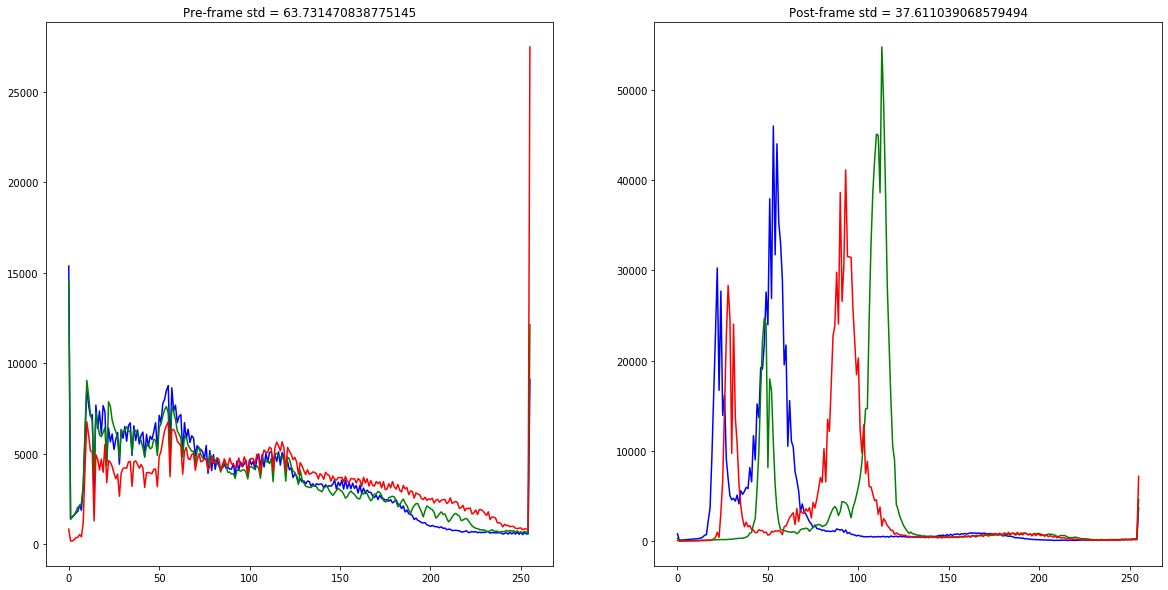

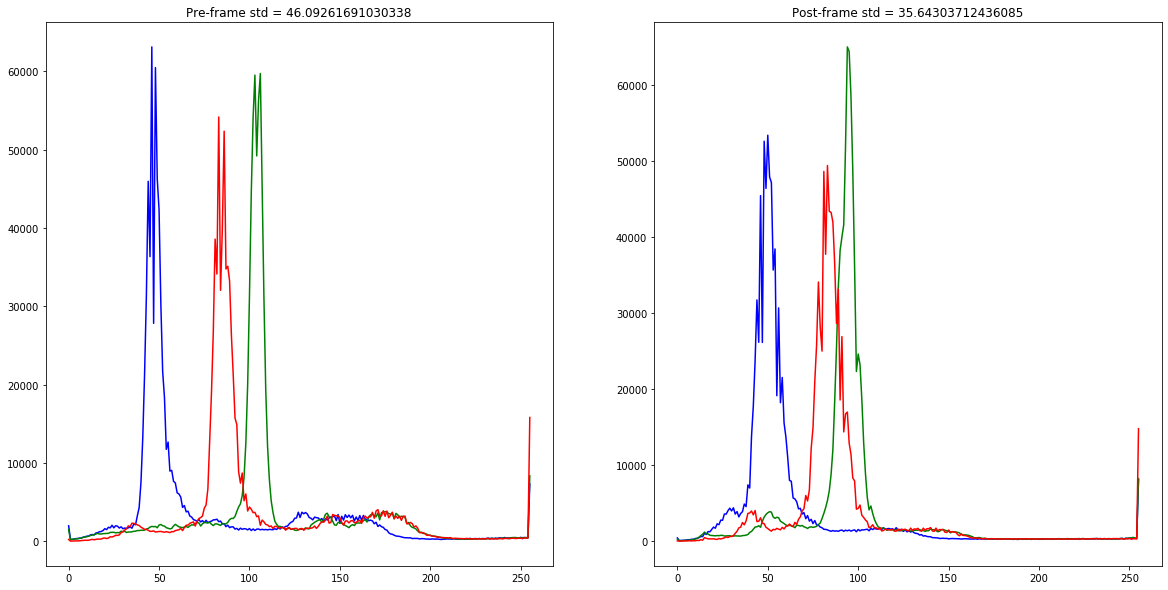

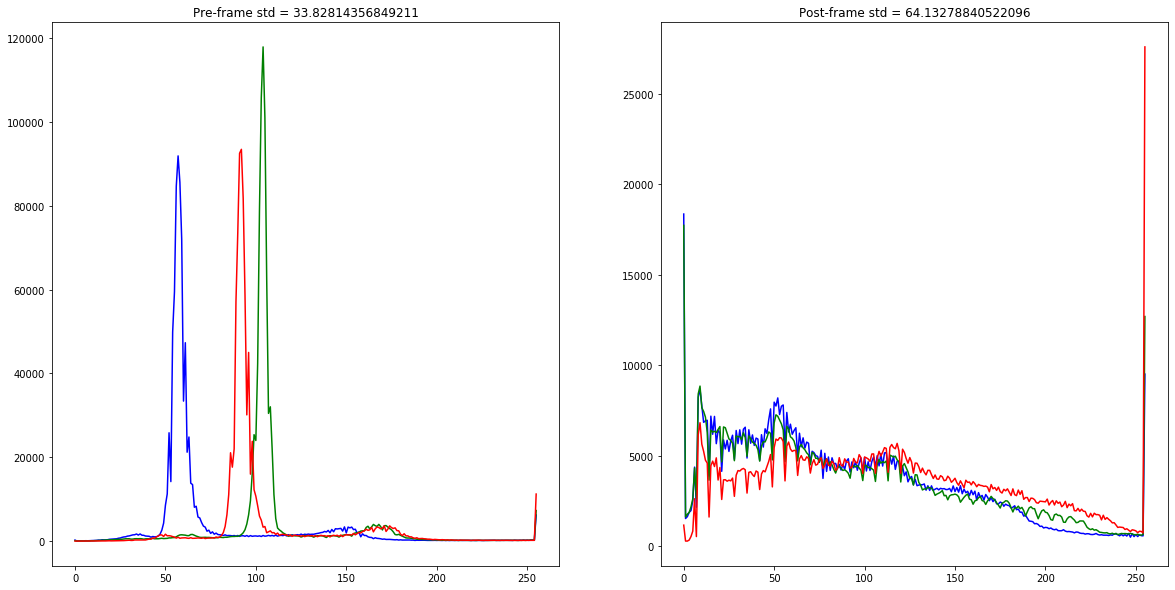

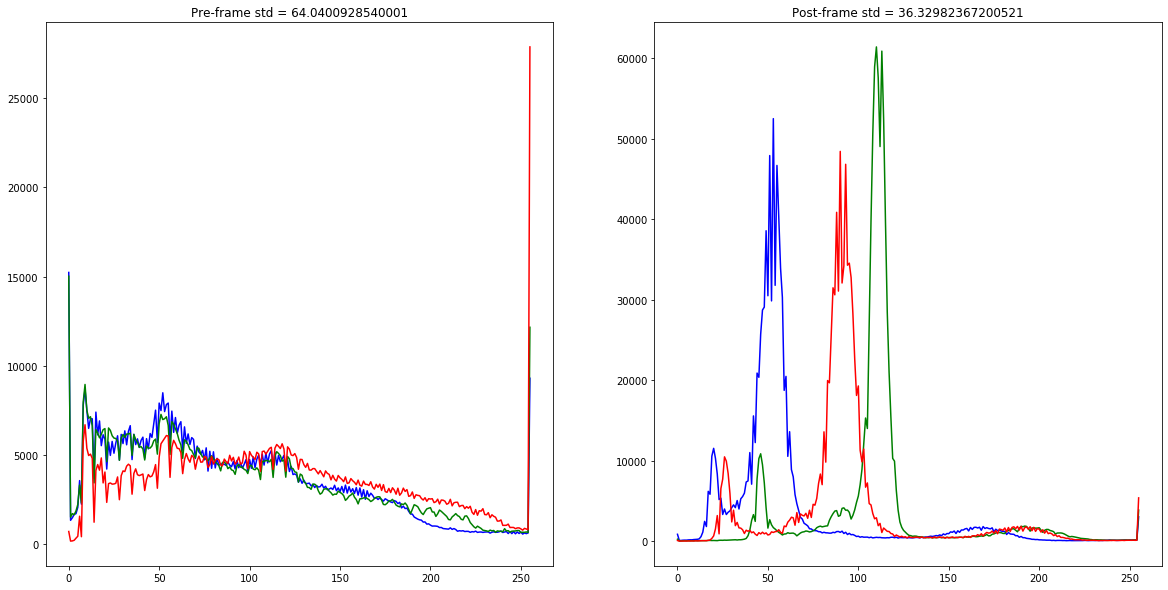

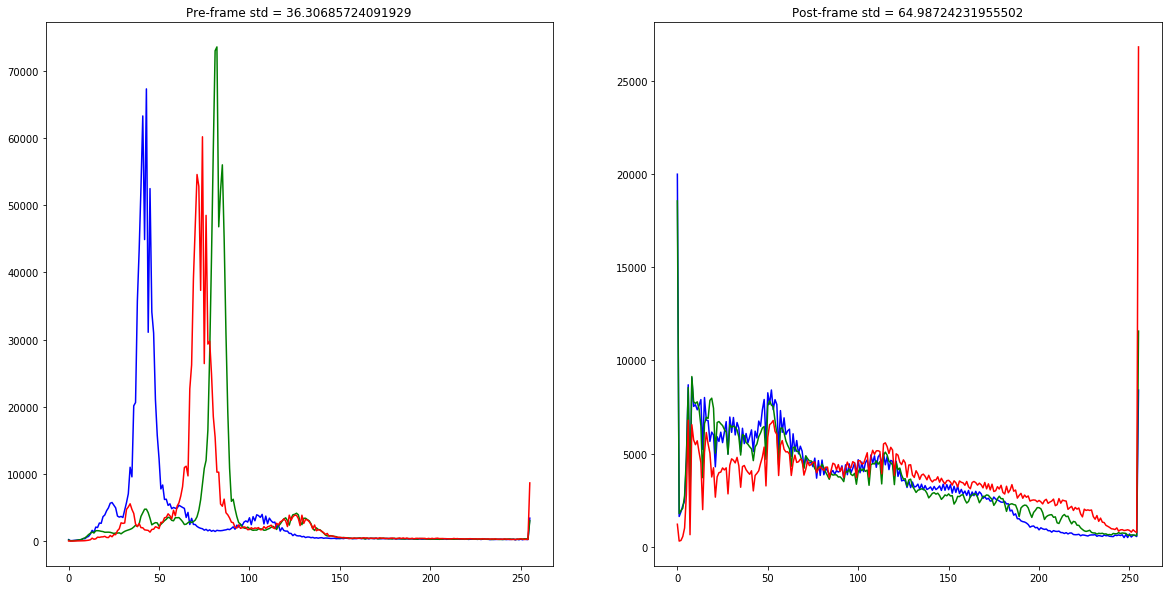

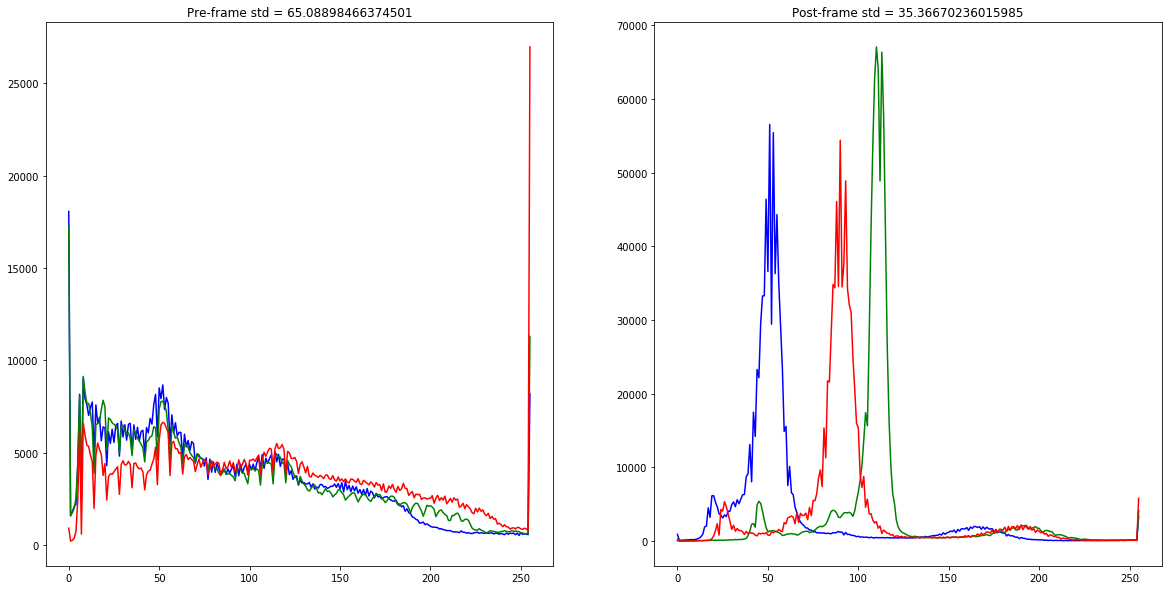

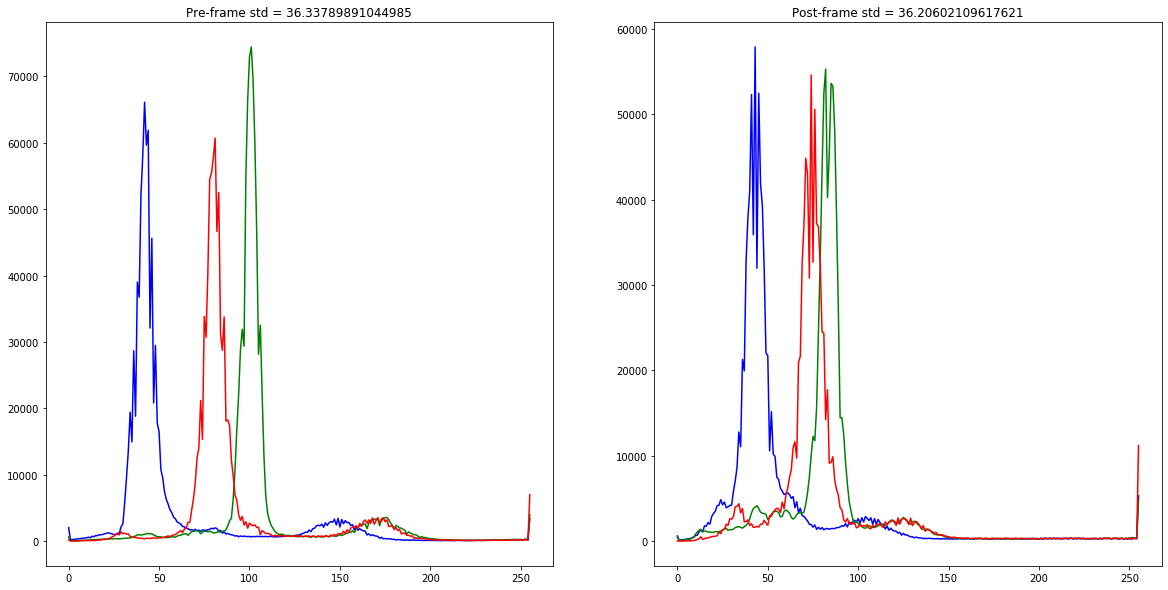

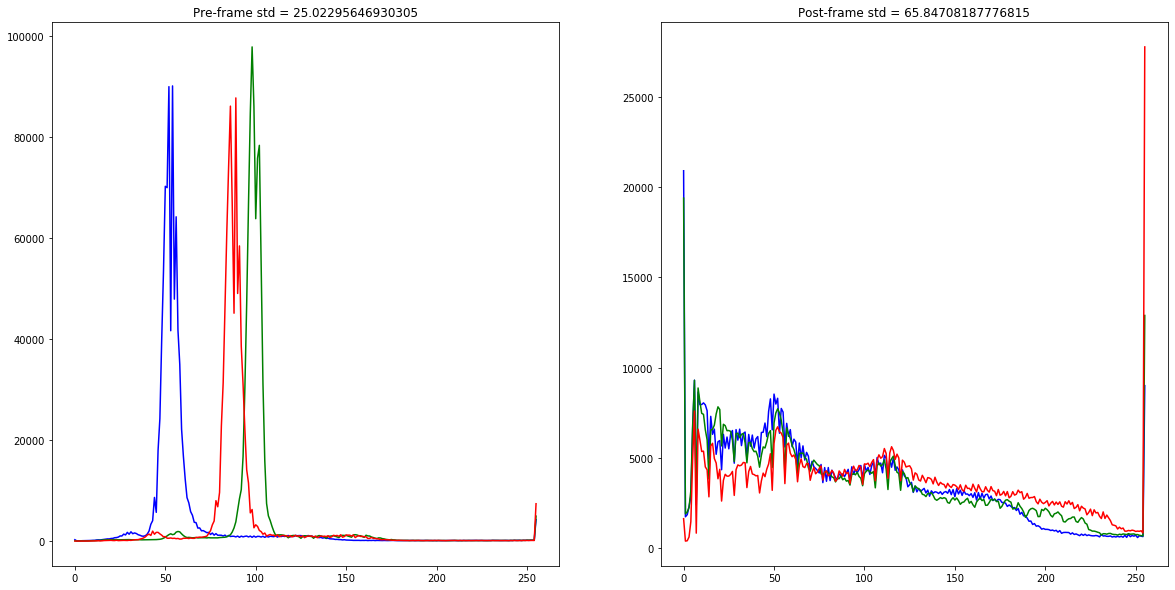

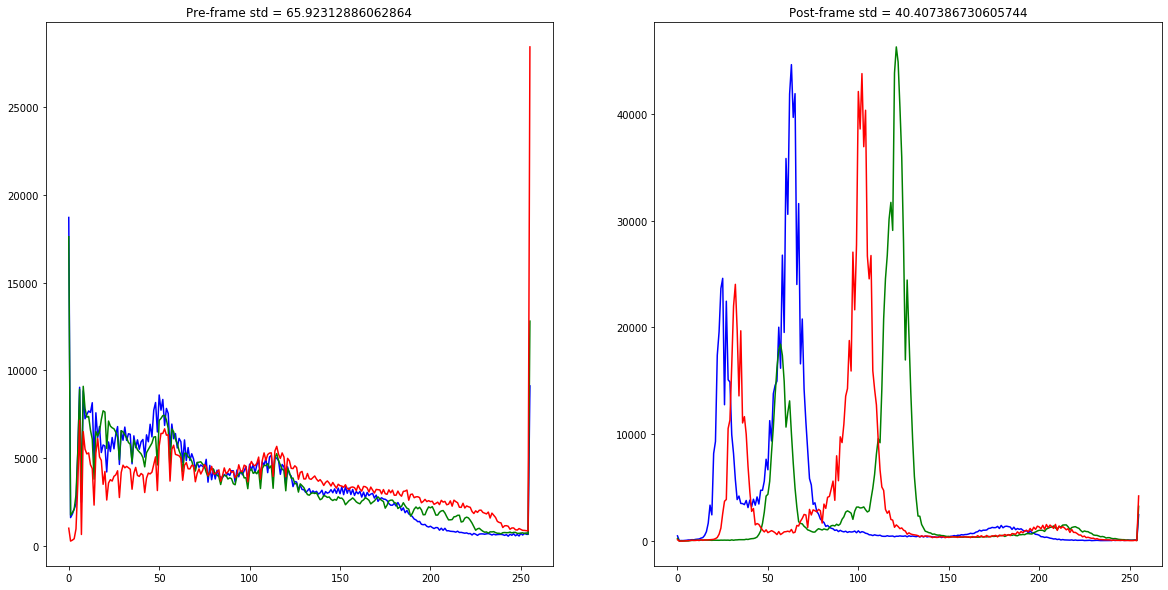

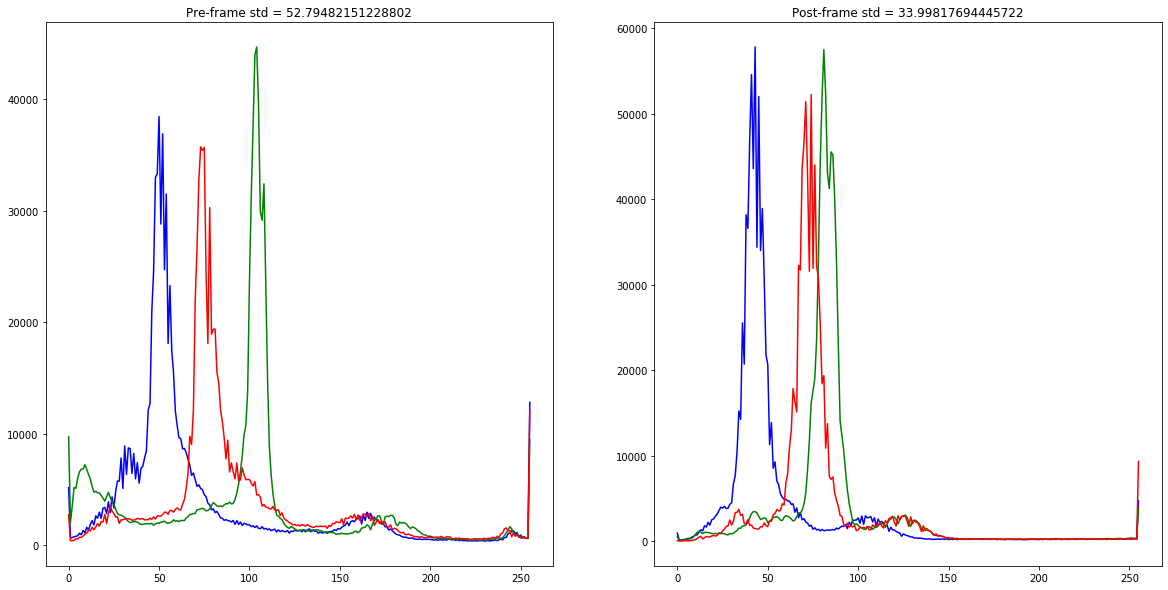

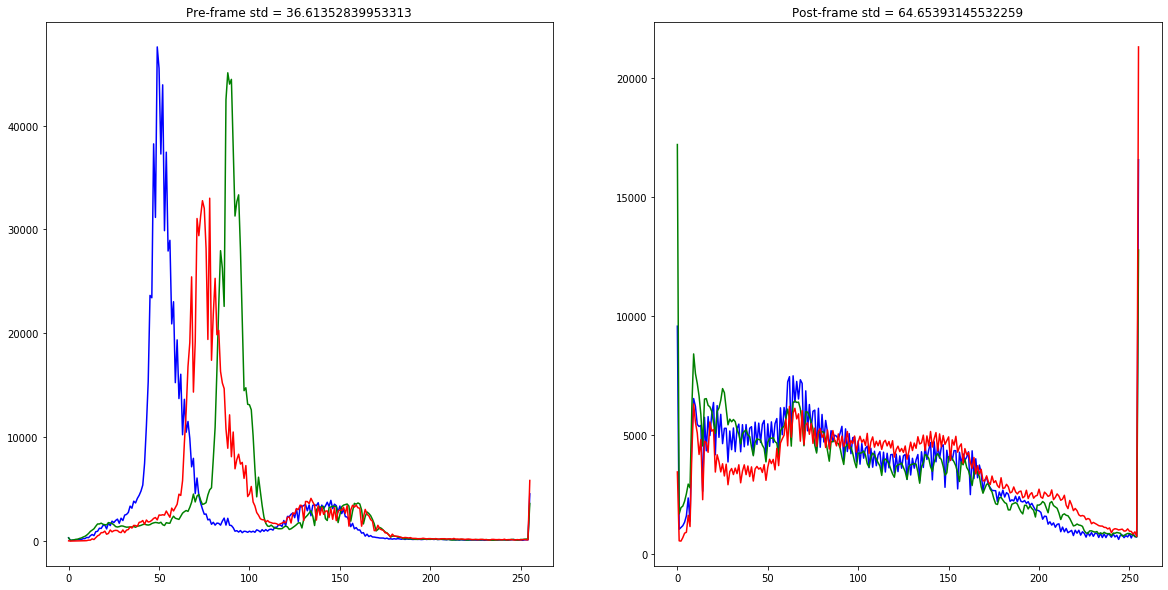

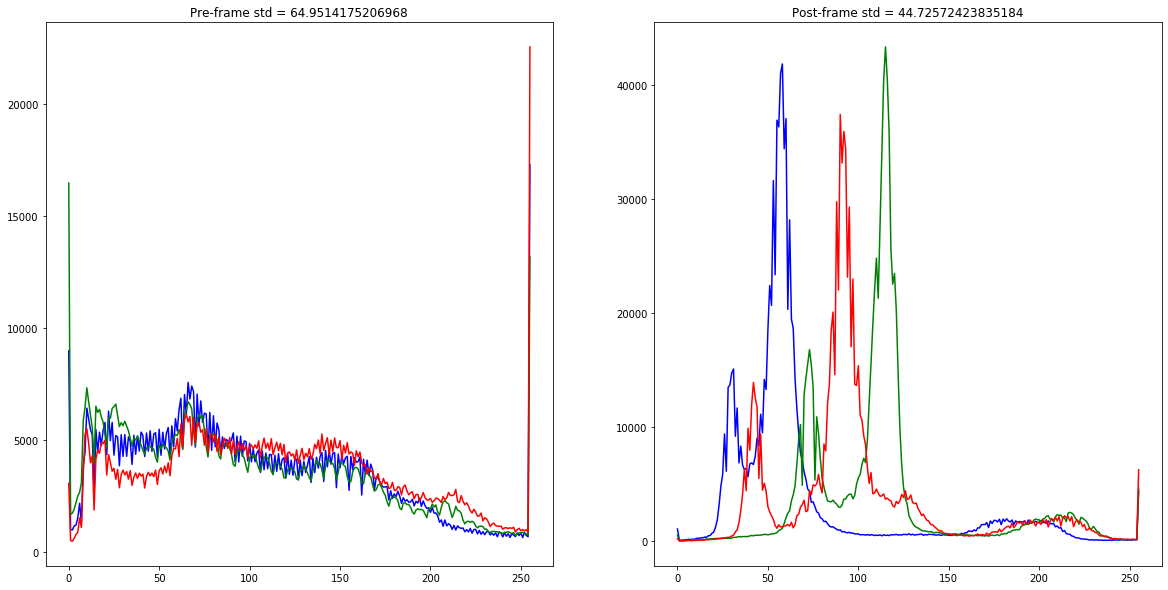

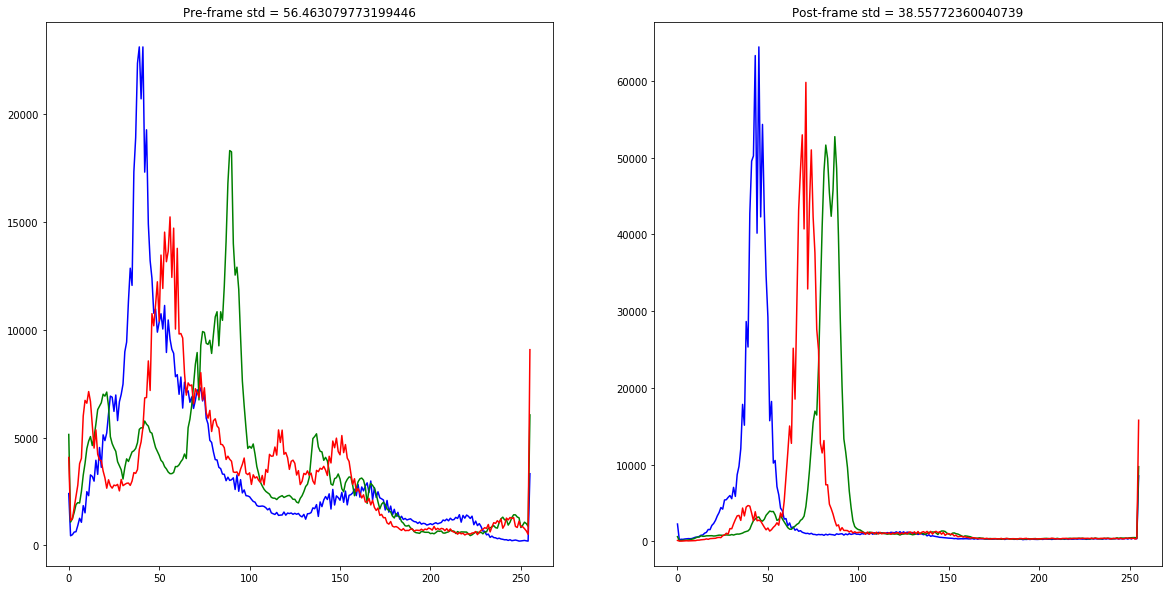

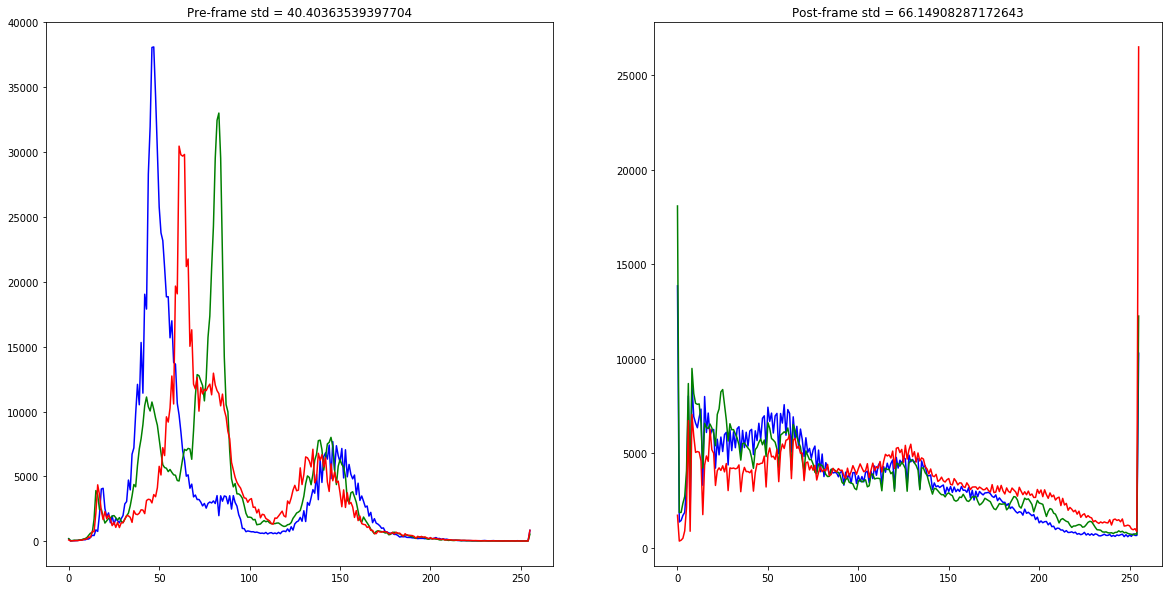

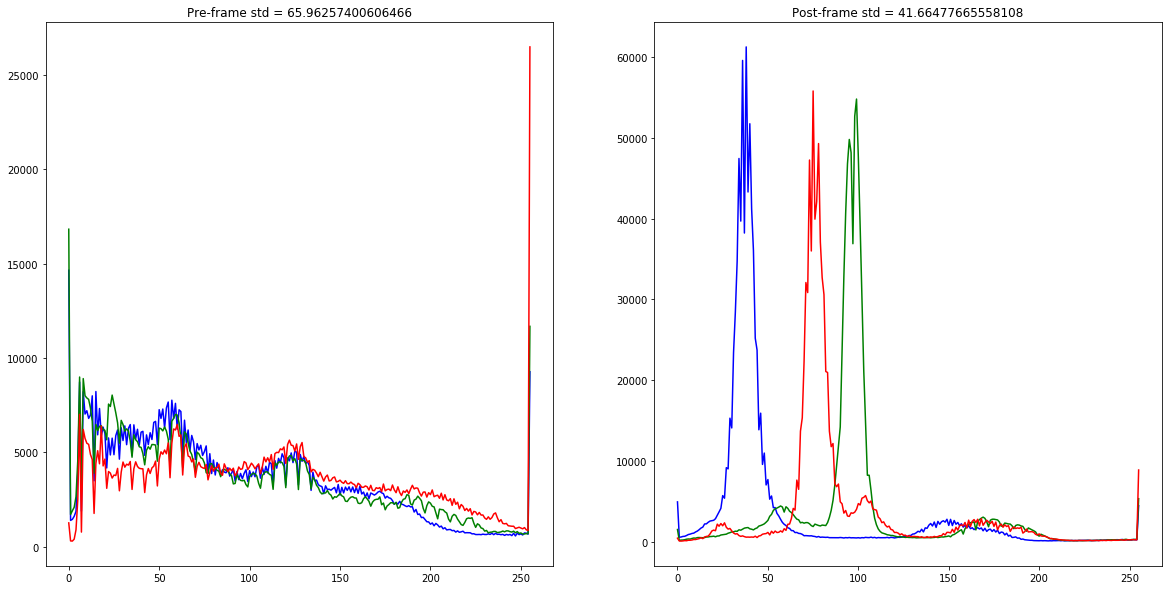

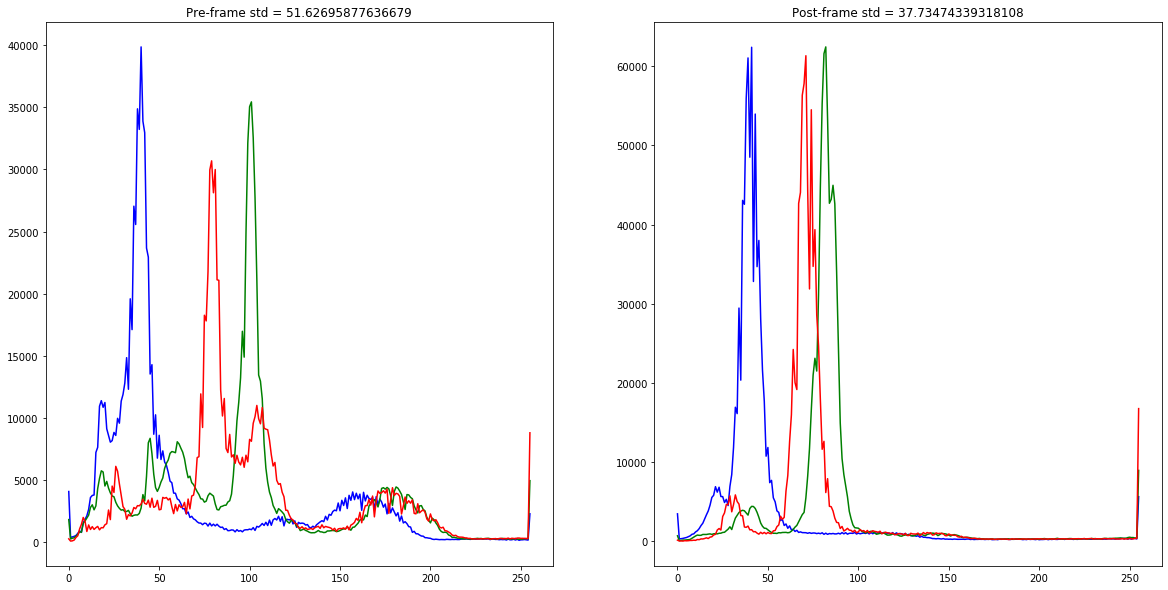

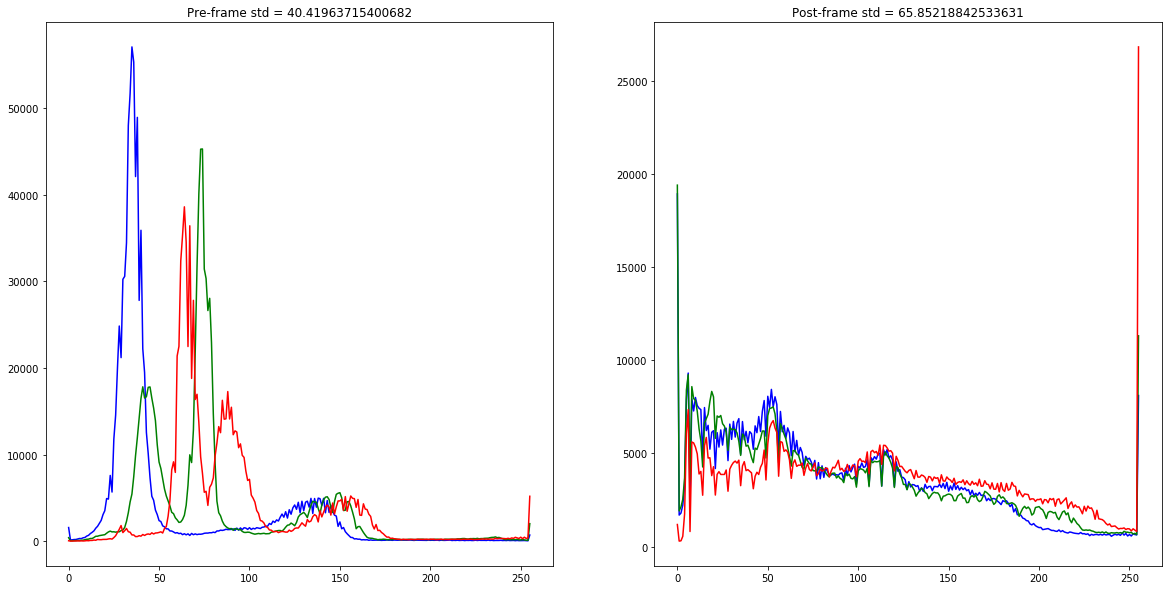

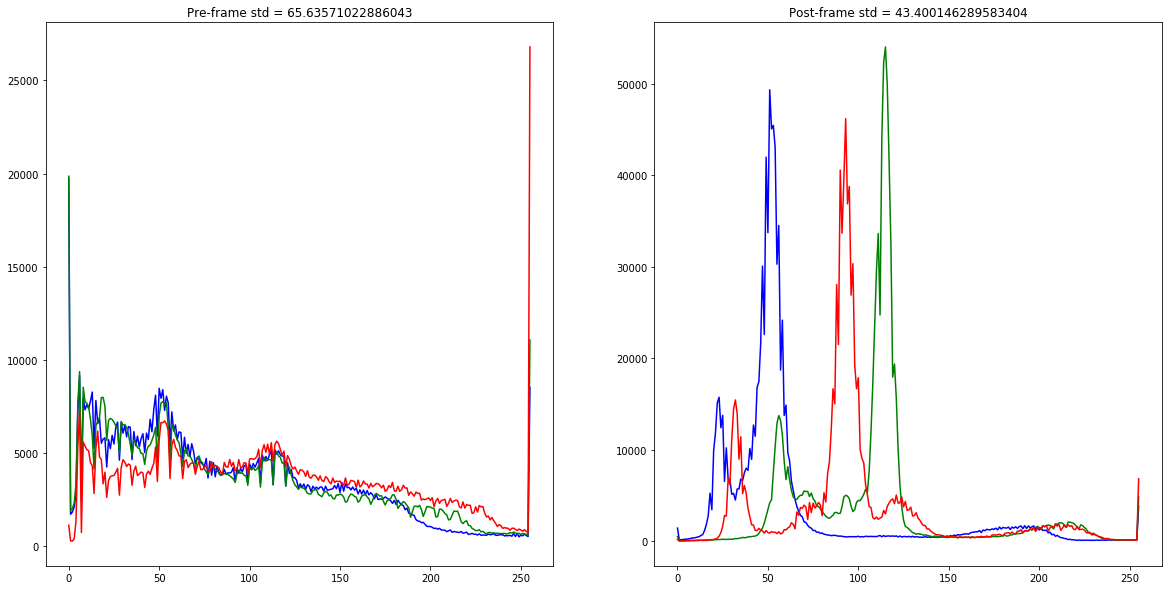

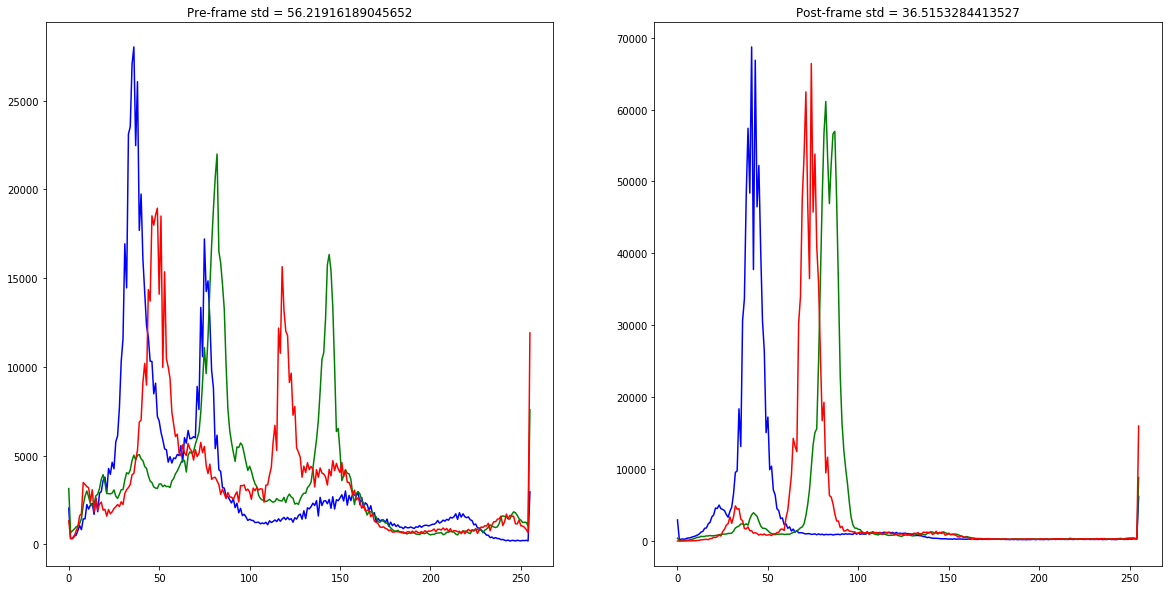

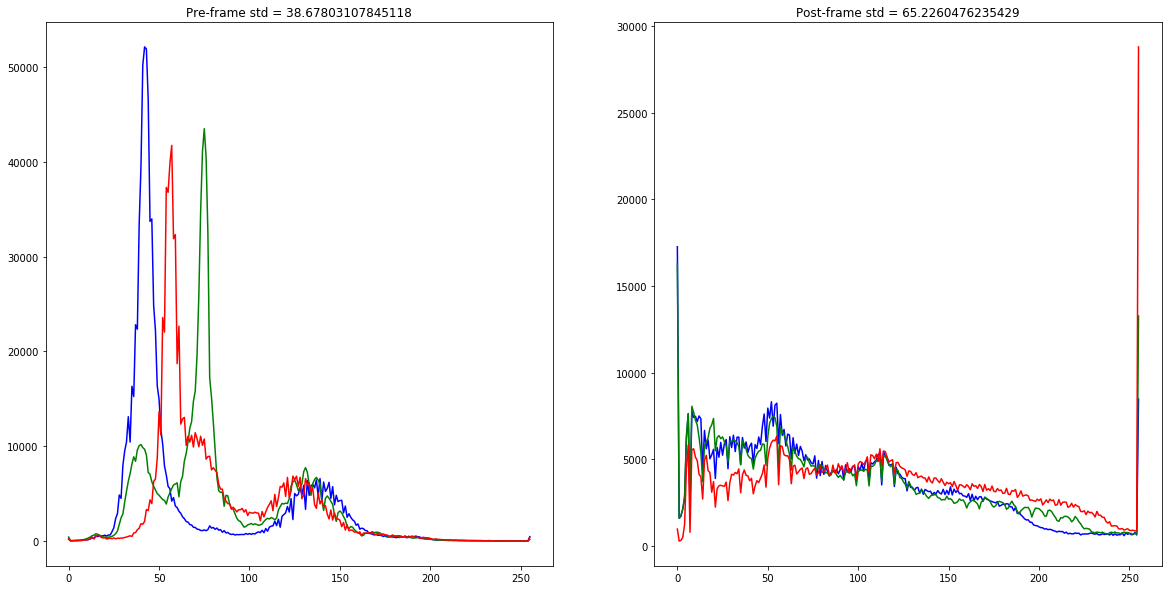

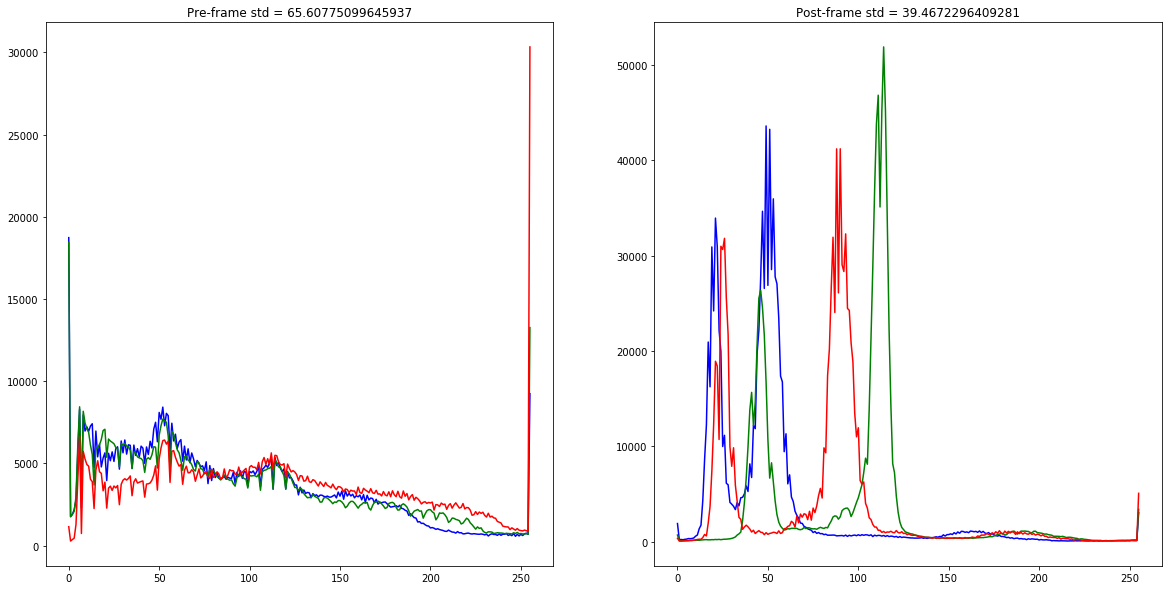

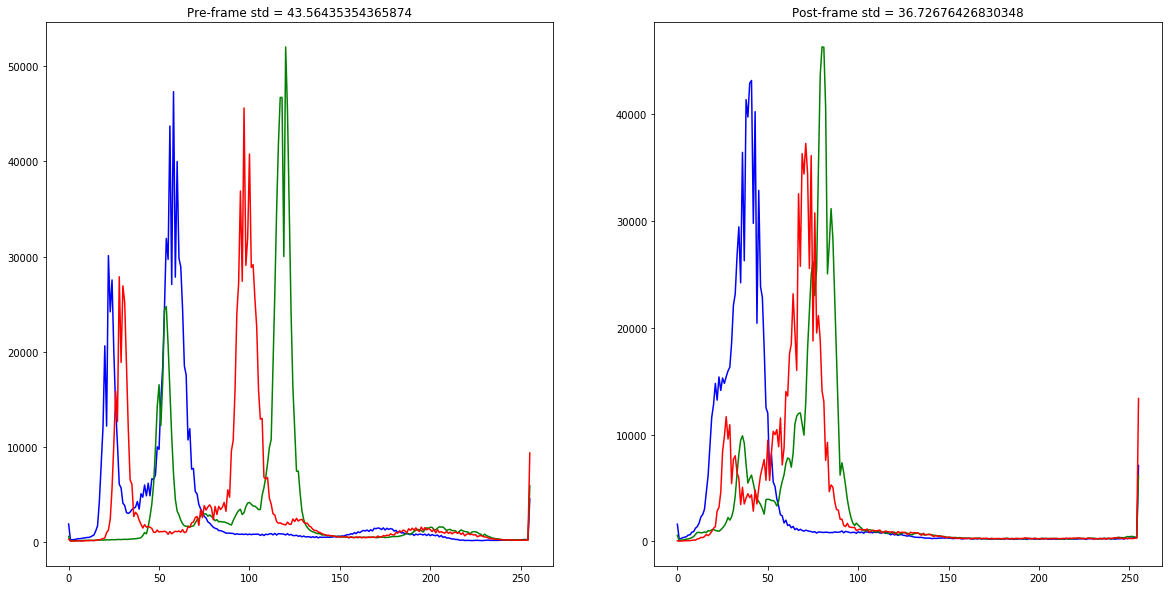

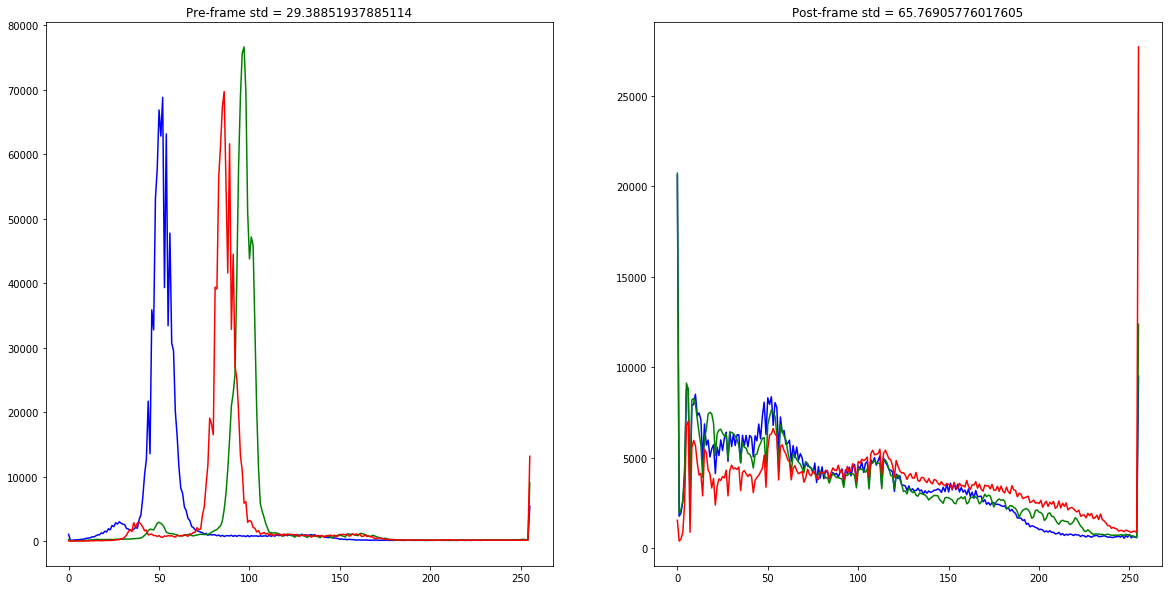

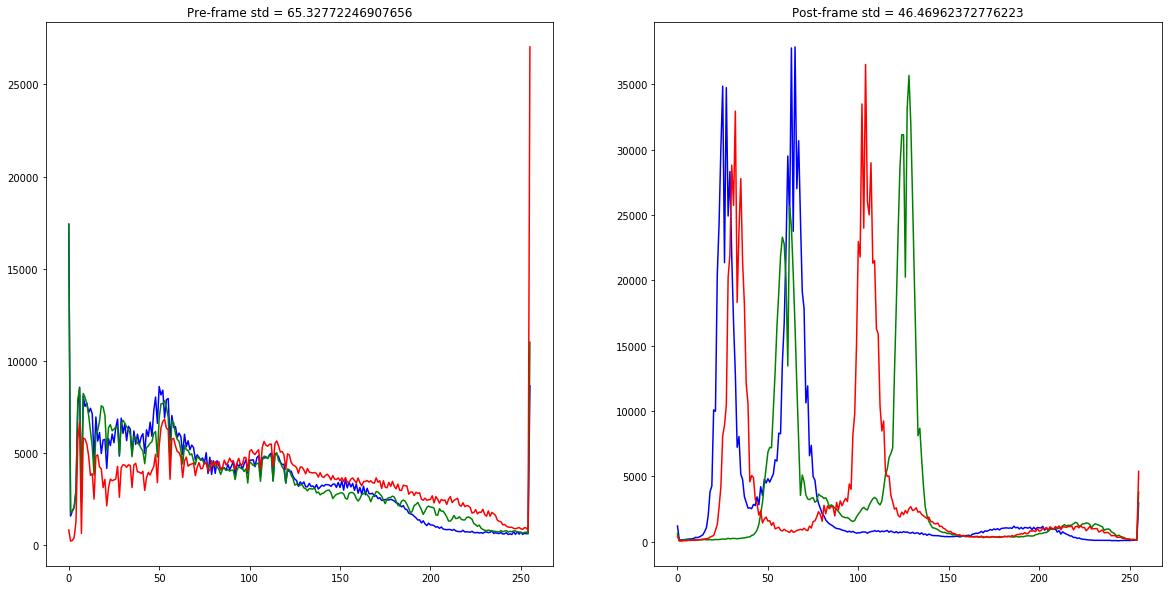

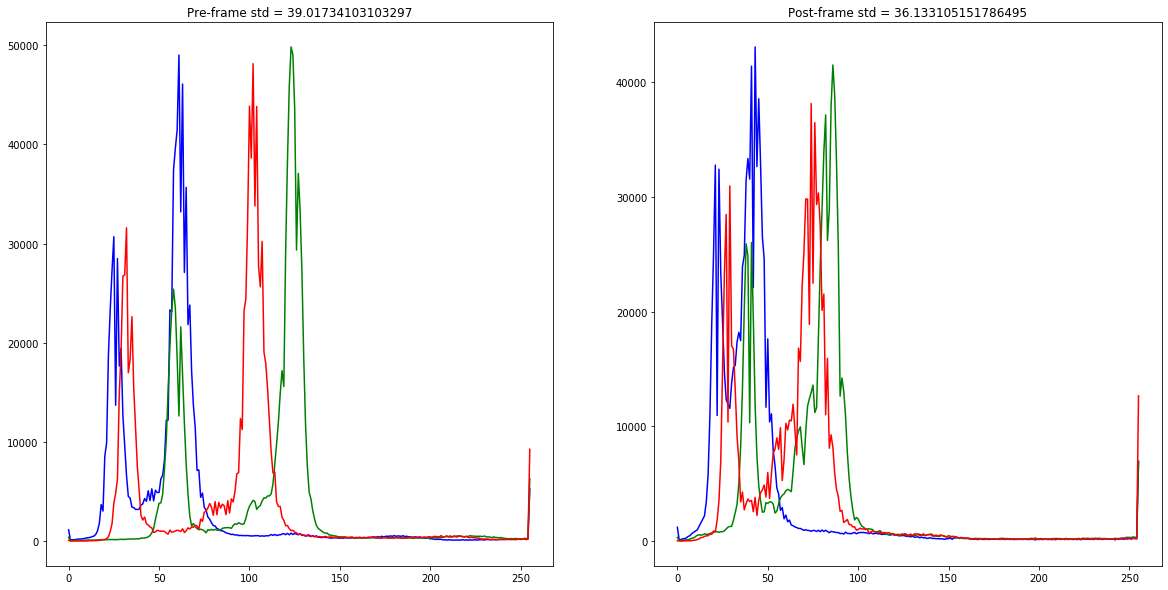

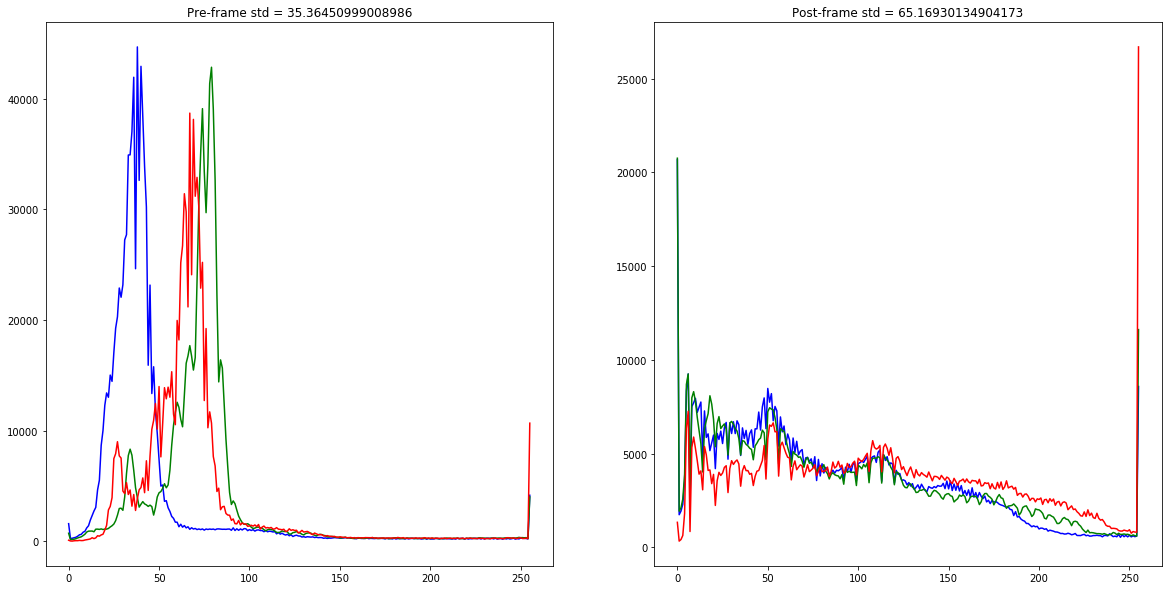

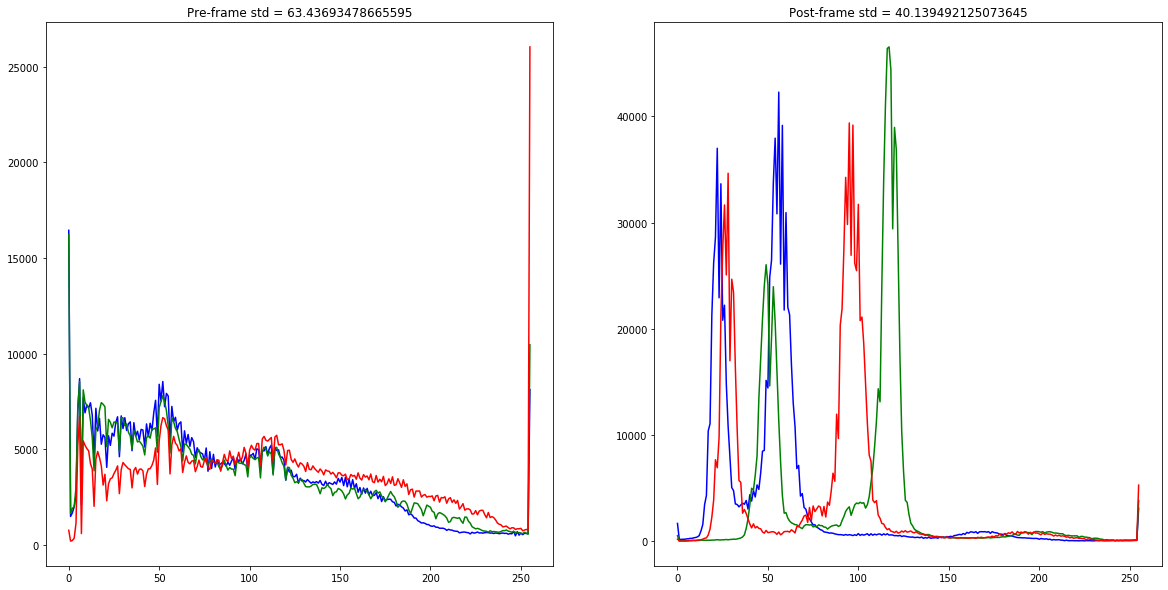

In [104]:
#loop through all of the potential switch frames
framewin = 10
count = 0
allrgbstds = []
hist_results = np.zeros([3*np.shape(switchFrames)[0],5])
for i in np.arange(np.shape(switchFrames)[0]):
    #get a window of frames around the switch time
    #frames_pre_switch = frames[switchFrames[i]-framewin:switchFrames[i]]
    #frames_post_switch = frames[switchFrames[i]:switchFrames[i]+framewin]
    frames_pre_switch = frames[switchFrames[i]-framewin:switchFrames[i]-int(framewin/2)]
    frames_post_switch = frames[switchFrames[i]+int(framewin/2):switchFrames[i]+framewin]
    
    #get the histograms of color before and after the switch times
    color = ('b','g','r')
    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    whichresultrows = [];
    for j,col in enumerate(color):
        #calculate the histogram for the colors
        hist_pre = cv2.calcHist(frames_pre_switch,[j],None,[256],[0,256])
        hist_post = cv2.calcHist(frames_post_switch,[j],None,[256],[0,256])
        
        #calculate the mean and median values of the distribution
        frames_pre_switch_flat = [];
        frames_post_switch_flat = [];
        for k in np.arange(np.shape(frames_pre_switch)[0]):
            frame2use_pre = frames_pre_switch[k]
            frames_pre_switch_flat.append(np.ravel(frame2use_pre[:,:,j])) #get channel with the specific color    
            frame2use_post = frames_post_switch[k]
            frames_post_switch_flat.append(np.ravel(frame2use_post[:,:,j])) #get channel with the specific color 
            
        #values will be stored in rows ordered r,g,b for every switch frame
        hist_results[count,0] = np.mean(frames_pre_switch_flat)       #pre-frame mean
        hist_results[count,1] = np.std(frames_pre_switch_flat)        #pre-frame std
        hist_results[count,2] = switchFrames[i]                       #frame that the data is from
        hist_results[count,3] = np.mean(frames_post_switch_flat)      #post-frame mean
        hist_results[count,4] = np.std(frames_post_switch_flat)       #post-frame std
        whichresultrows.append(count)
        count = count+1
        
        #plot the data
        ax[0].plot(hist_pre,color = col)
        ax[1].plot(hist_post,color = col)
        
    #get average std for all colors and append
    meanstd_pre = np.mean(hist_results[whichresultrows,1])
    meanstd_post = np.mean(hist_results[whichresultrows,4])
    allrgbstds.append([meanstd_pre, meanstd_post])
    title_pre = 'Pre-frame std = ' + str(meanstd_pre)
    title_post = 'Post-frame std = ' + str(meanstd_post)
    ax[0].set_title(title_pre)
    ax[1].set_title(title_post)
    
    #save the plot figures to a folder
    filename = "figures/rgbhist-prepostswitch/switchframe" + str(i) + ".png"
    plt.gcf()
    plt.savefig(filename)
    plt.show()

#save the results to a csv
np.savetxt('results/rgbhist-5-min-video.csv',hist_results,delimiter=',')


Using the standard deviations of the RGB distributions, we will classify the switch times as the start or end of a scoreboard angle or play angle

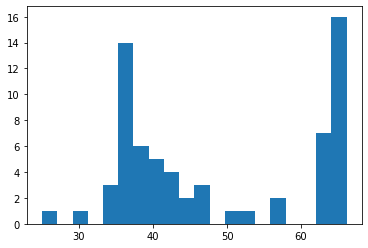

In [192]:
#plot the distribution of standard deviations to find a good classification point
allstds = np.ravel(allrgbstds)
plt.hist(allstds,bins=20)

#save the data
filename = "figures/std-rgb-hist.png"
plt.gcf()
plt.savefig(filename)
plt.show()

In [197]:
std_threshold = 60 #any RGB spectrum with a std greater than 60 will be classified as scoreboard

#classify whether the pre and post frames contained the scoreboard
scoreboard_start_idx = [] 
scoreboard_end_idx = []
play_start_idx = []
scoreboard_start_idx.append(0) #game starts with scoreboard
class_mat = np.zeros([np.shape(allrgbstds)[0],2]) #0 indicates play, 1 indicates scoreboard
for i in np.arange(np.shape(allrgbstds)[0]):
    std_temp = allrgbstds[i]
    if std_temp[0] > stdthreshold:
        class_mat[i,0] = 1
        scoreboard_end_idx.append(switchFrames[i])
        
        #given the structure of the videos, we want the view from the 50 yard line 
        #this comes right after the scoreboard play ends
        play_start_idx.append(switchFrames[i])
    if std_temp[1] > stdthreshold:
        class_mat[i,1] = 1
        scoreboard_start_idx.append(switchFrames[i])    

#combine start and end times into single matrix
scoreboard_frames = np.zeros([np.shape(end_idx)[0],2])
scoreboard_frames[:,0] = start_idx
scoreboard_frames[:,1] = end_idx

#save the results to a csv
np.savetxt('results/scoreboard-frames-5-min-video.csv',scoreboard_frames,delimiter=',')
np.savetxt('results/play-start-frames-5-min-video.csv',play_start_idx,delimiter=',')